#### Notebook `Data Preprocessing`

#### Group:
- `Miguel Matos - 20221925`
- `André Nicolau - 20221861`
- `André Ferreira - 20250398`

---

#### <font> Table of Contents </font> <a class="anchor" id='toc'></a> 
1. [Imports](#Imports)
2. [Data Preprocessing](#data-preprocessing)

- 2.1. [Missing Values](#missing-values)
- 2.2. [Outliers](#outliers)
- 2.3. [Encoding Categorical Variables](#encoding-categorical-variables)
- 2.4. [Feature Engeneering](#feature-engeneering)


----

# Imports
[Back to TOC](#toc)

In [1]:
from functions import *
data = pd.read_csv("D:/Faculdade/Mestrado/Data Mining/Data Mining_ Materials/ML_Project_Group42/data/data_cleaned.csv", index_col= "carID")
pd.set_option("display.max_columns", None)

# Data Preprocessing

Now, we want to split the data, and use "Brand" to stratify the data. For that, we need to make sure there are no missing values on "Brand".

In [2]:
data.isna().sum()

Brand              236
model             1517
car_age           1491
price                0
transmission      1522
mileage           1832
fuelType          1515
tax               8282
mpg               7962
engineSize        1600
paintQuality%     1891
previousOwners    1921
dtype: int64

As there are only 236 rows in "Brand" with missing values, and we want to use "Brand" to stratify the data, we'll delete these rows.

In [3]:
data.dropna(subset=["Brand"], inplace=True)

Let's splitt the data now.

In [4]:
cars_data = data.drop("price", axis = 1)
target_data = data["price"]

In the following cell, we'll split the data into 70% for train and 30% for test, as we have a big amount of data (around 75k rows).


In [5]:
X_train, X_val, y_train, y_val = train_test_split(cars_data, target_data, 
                                                    test_size= 0.3, 
                                                    random_state= 7, # 7 because of Ronaldo :)
                                                    shuffle= True, # True, because the data is ordered by brands
                                                    stratify = cars_data["Brand"])

In [6]:
print(f"The length of the training data is {len(X_train)}.")
print(f"The length of the validation data is {len(X_val)}.")

The length of the training data is 53015.
The length of the validation data is 22722.


## Missing Values
[Back to TOC](#toc)

In [7]:
X_train.isna().sum()

Brand                0
model             1069
car_age           1055
transmission      1056
mileage           1290
fuelType          1086
tax               5796
mpg               5594
engineSize        1163
paintQuality%     1264
previousOwners    1343
dtype: int64

### Impute Numerical

Our strategy for imputing missing values in the numerical features was to apply a K-Nearest Neighbors (KNN) imputation separately for each brand.
We chose this approach because performing the imputation within each brand allows the algorithm to better approximate realistic values, because vehicles from the same brand typically share similar characteristics and performance patterns.

Since the KNN algorithm relies on distance calculations between data points, it is necessary to scale the numeric variables within each brand before applying the imputation.
After imputing the missing values, we reversed the scaling to return the data to its original, interpretable scale.

In [8]:
metric_features = ["car_age", "mileage", "engineSize", "paintQuality%", "previousOwners", "tax", "mpg"]

In [9]:
#Here we are scaling for each brand 

imputer = KNNImputer(n_neighbors=5, weights="uniform")


imputed_list = [] #to store the imputed results


for brand, df_brand in X_train.groupby("Brand"):

    df_temporary = df_brand.copy() #so that we don't modify the original

    scaler = StandardScaler() #Define the Scaler


    scaled_data = scaler.fit_transform(df_temporary[metric_features]) #Scale an transform the data

    imputed_scaled = imputer.fit_transform(scaled_data)  #Apply KNN imputer on scaled data

    df_temporary[metric_features] = scaler.inverse_transform(imputed_scaled) #Reverse scaling

    
    imputed_list.append(df_temporary) # Adding each dataframe to our imputed_list


X_train_imputed = pd.concat(imputed_list, axis=0)   # Combine all brands again
X_train_imputed = X_train_imputed.loc[X_train.index]  # restore original order

In [10]:
X_train_imputed.isna().sum()

Brand                0
model             1069
car_age              0
transmission      1056
mileage              0
fuelType          1086
tax                  0
mpg                  0
engineSize           0
paintQuality%        0
previousOwners       0
dtype: int64

As we can see, we have an issue with the variable previousOwners. Since it represents the number of owners a car has had, its values should always be integers. However, after applying the KNN imputation, this is no longer the case because the algorithm calculates values based on distances.
To address this, we decided to round the imputed values to the nearest integer, so we floored values below 0.5 and rounded up those above 0.5. This ensures the values remain realistic while preserving the underlying relationships in the data.

In [11]:
X_train_imputed[X_train_imputed["previousOwners"] % 1 !=0]

,Brand,model,car_age,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners
carID,,,,,,,,,,,
69196,VW,Polo,6.0,Manual,34491.0,Petrol,150.0,64.2,1.0,45.0,2.8
48323,Skoda,Fabia,6.0,Manual,3275.0,Petrol,145.0,61.4,1.0,75.0,2.4
26857,Ford,Fiesta,12.0,Manual,62300.0,Petrol,0.0,65.7,1.0,55.0,0.6
16358,Ford,Fiesta,9.0,Manual,44787.0,Petrol,125.0,54.3,1.2,75.0,2.2
46970,Skoda,Fabia,7.0,Manual,34213.0,Petrol,150.0,64.2,1.0,86.0,1.4
...,...,...,...,...,...,...,...,...,...,...,...
67150,VW,Tiguan,5.0,Automatic,5000.0,Diesel,145.0,30.4,2.0,74.0,2.4
71566,VW,Cc,11.0,Manual,62541.0,Diesel,30.0,60.1,2.0,87.0,1.2
75951,VW,NaN,9.0,Automatic,56838.0,Diesel,240.0,42.8,3.0,97.0,1.4


In [12]:
X_train_imputed["previousOwners"] = X_train_imputed["previousOwners"].round()

### Impute Categorical

For the categorical variables, we adopted a similar brand-specific approach as used for the numerical features.
However, instead of applying KNN imputation, we filled the missing values with the mode of each brand.

In [13]:
non_metric_features = ["model", "transmission", "fuelType"]

In [14]:
X_train_imputed["transmission"].value_counts(dropna=False)

transmission
Manual       29086
Semi-Auto    11700
Automatic    10660
NaN           1056
Unknown        510
Other            3
Name: count, dtype: int64

We still identified some "Unknown" values in the Transmission variable, which do not provide any meaningful information.
Before performing the imputation, these entries were converted into missing values to ensure they are treated consistently with other missing data.

In [15]:
X_train_imputed.loc[X_train_imputed["transmission"] == "Unknown", "transmission"] = np.nan

In [16]:
#Confirming if the Unknowns were transformed into NaNs
X_train_imputed["transmission"].value_counts(dropna=False)

transmission
Manual       29086
Semi-Auto    11700
Automatic    10660
NaN           1566
Other            3
Name: count, dtype: int64

In [17]:
#Doing the imputation withe the mode by brand
for col in non_metric_features:
    X_train_imputed[col] = X_train_imputed.groupby("Brand")[col].transform(lambda x: x.fillna(x.mode()[0]))

In [18]:
X_train_imputed.isna().sum()

Brand             0
model             0
car_age           0
transmission      0
mileage           0
fuelType          0
tax               0
mpg               0
engineSize        0
paintQuality%     0
previousOwners    0
dtype: int64

We handled all missing values in the training dataset

## Imputation of Validation Data set

We need to impute the missing values in our validation set using the same strategy that was applied to the training set, and we need to use the metrics derived from the training data to prevent data leakage

### Impute Numerical (X_val)

We used the KNN imputer by brand to impute our numeric data in our training data and for that we fitted the scaler and the imputer for each brand. Now we have to store all those scalers and imputers that are fitted from our trainning data to use them to fill our validation data

In [19]:
Brand_scalers = {}
Brand_imputers = {}

for brand, df_brand in X_train.groupby("Brand"):
    scaler = StandardScaler()
    imputer = KNNImputer(n_neighbors=5, weights="uniform")
    
    scaled = scaler.fit_transform(df_brand[metric_features])
    imputed = imputer.fit_transform(scaled)
    
    X_train_imputed.loc[df_brand.index, metric_features] = scaler.inverse_transform(imputed)
    
    Brand_scalers[brand] = scaler
    Brand_imputers[brand] = imputer

Impute the missing values of the validadtion data set, using scalers and imputers of the trainning set

In [20]:
X_val_imputed = X_val.copy()

for brand, df_brand in X_val.groupby("Brand"):

    scaler = Brand_scalers[brand]       #Getting the scaler and the imputer from the dictionaries
    imputer = Brand_imputers[brand]

    scaled_val = scaler.transform(df_brand[metric_features]) #Transform using X_train Scalers
    imputed_scaled = imputer.transform(scaled_val)           #Transform using X_train imputers
        
    X_val_imputed.loc[df_brand.index, metric_features] = scaler.inverse_transform(imputed_scaled) #Reverse the scaling

In [21]:
X_val_imputed.isna().sum()

Brand               0
model             412
car_age             0
transmission      460
mileage             0
fuelType          426
tax                 0
mpg                 0
engineSize          0
paintQuality%       0
previousOwners      0
dtype: int64

### Impute Categorical (X_Val)

We will store the mode from each variable in each brand, so that afterward we impute them in validation data set

In [22]:
brand_modes = {} #Dictionary with the modes of each variable in ecah brand

for brand, df_brand in X_train.groupby("Brand"): #group by each brand
    brand_modes[brand] = {}                      #create a dictionary for each brand to strore th mode of each variable

    for col in non_metric_features:              # iterate through each categorical feature
        mode_values = df_brand[col].mode()       #get the mode

        brand_modes[brand][col] = mode_values[0] #add to the dictionary

In [23]:
for brand, df_brand in X_val_imputed.groupby("Brand"):
    for col in non_metric_features:
        mode_value = brand_modes[brand][col]
        X_val_imputed.loc[df_brand.index, col] = df_brand[col].fillna(mode_value)

In [24]:
X_val_imputed.isna().sum()

Brand             0
model             0
car_age           0
transmission      0
mileage           0
fuelType          0
tax               0
mpg               0
engineSize        0
paintQuality%     0
previousOwners    0
dtype: int64

## Scale of validation data set

## Outliers
[Back to TOC](#toc)

Firstly, let's visualize the data distribution of our trainning data.

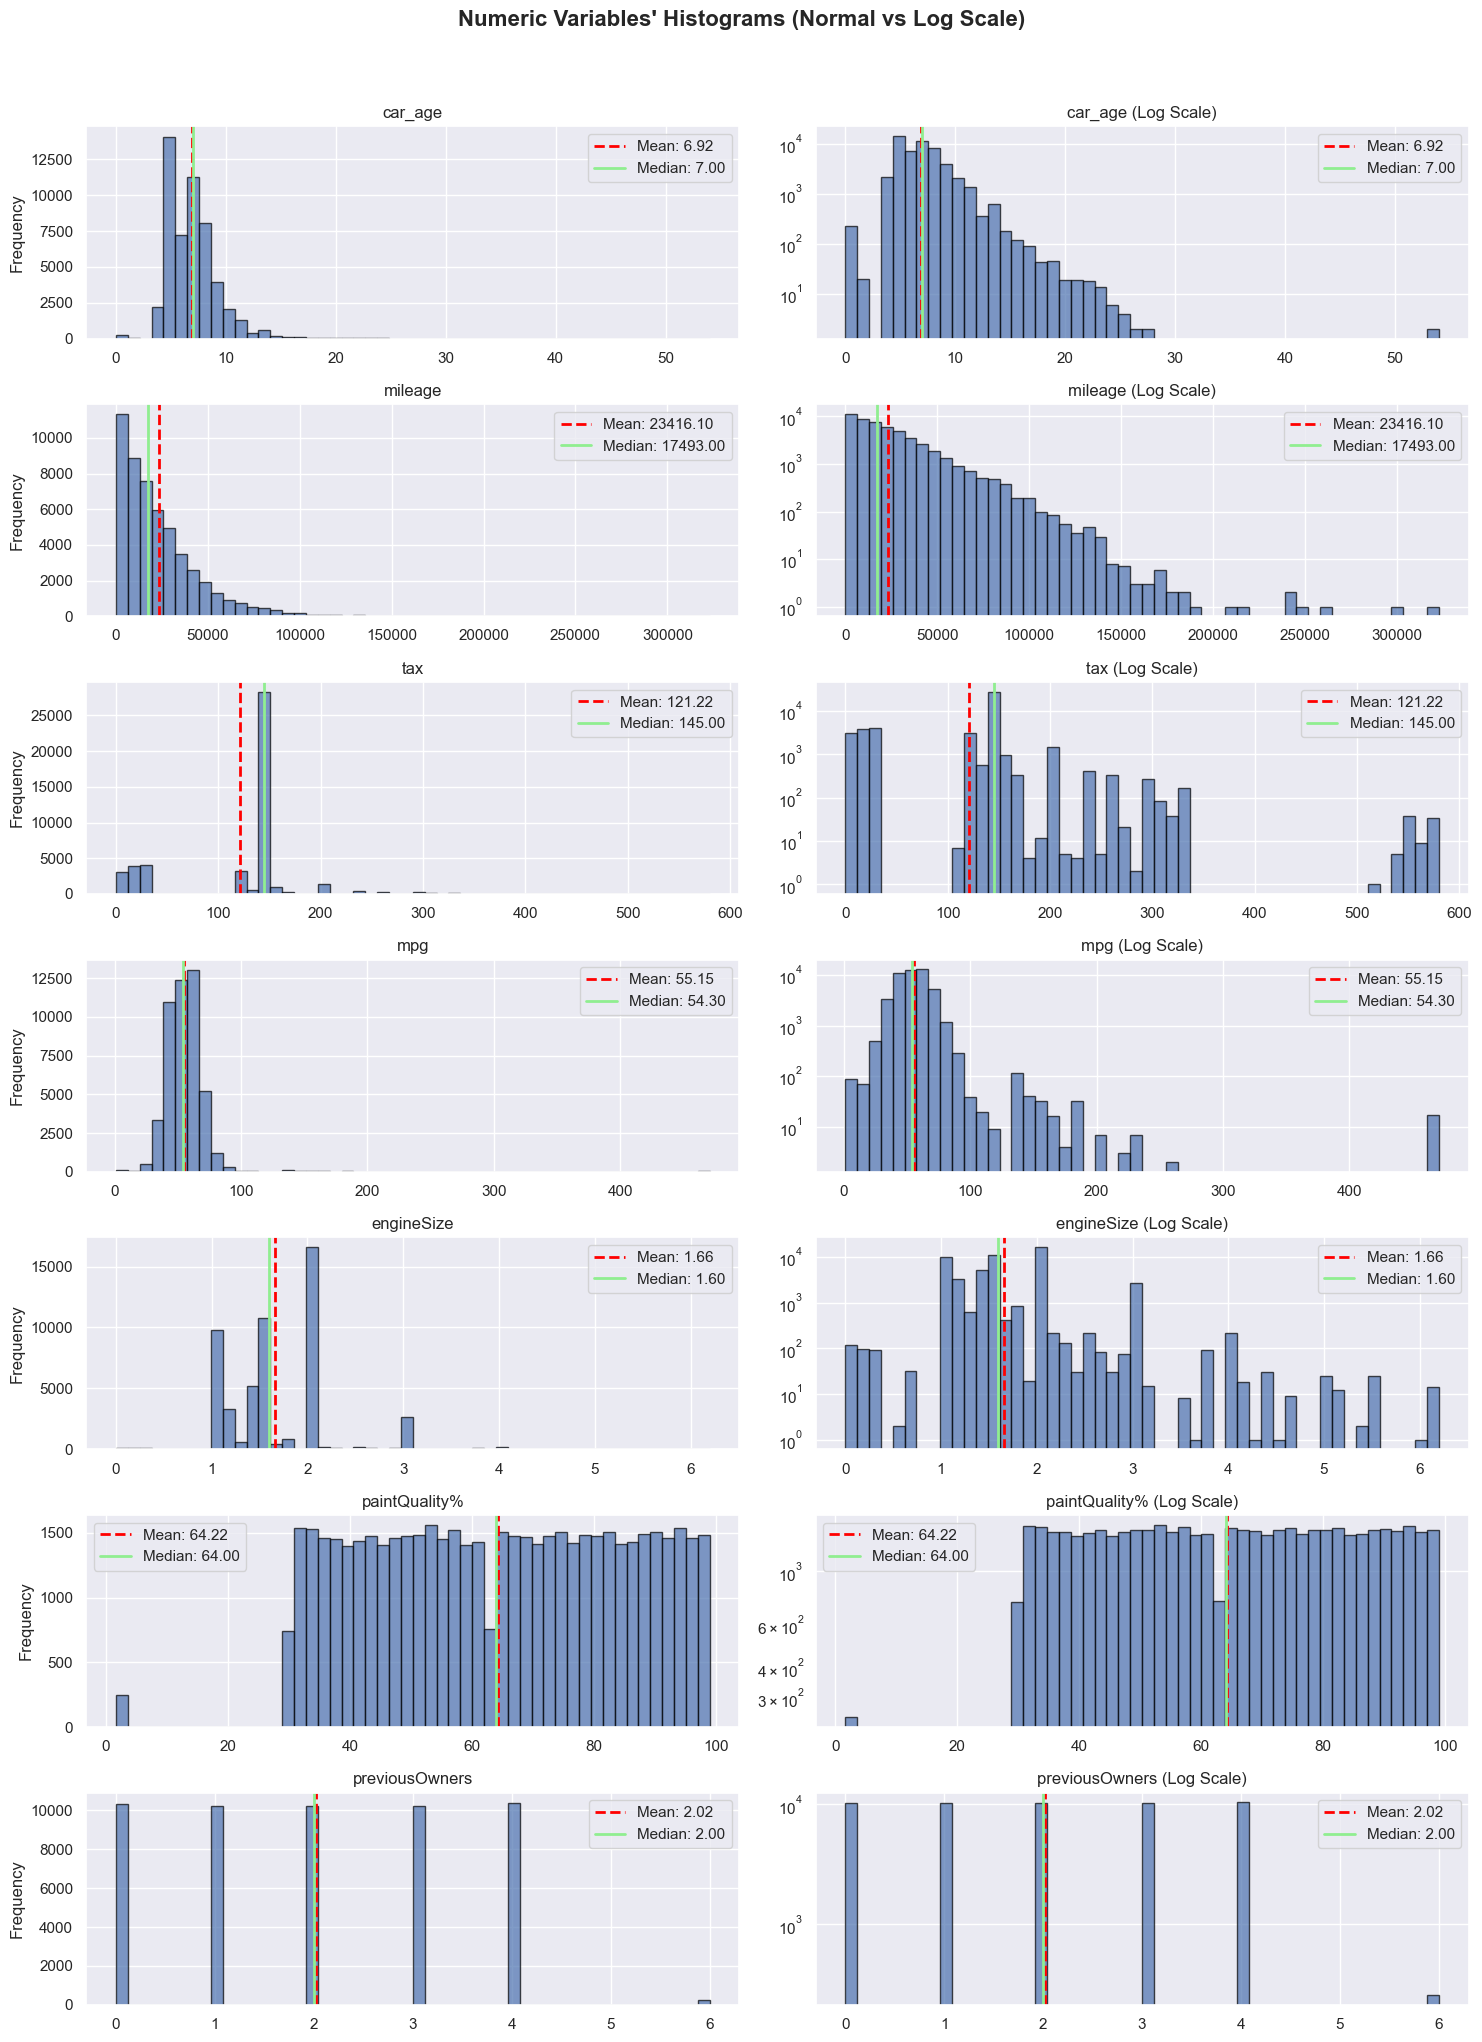

In [25]:
# Plot ALL Numeric Variables' Histograms in one figure
sns.set(style= "darkgrid")

metric_features = X_train.select_dtypes(include=np.number)

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(7, 2, figsize=(15, 20))

# Loop through each feature
for i, feat in enumerate(metric_features):

    # Calculate mean and median
    mean_val = X_train[feat].mean()
    median_val = X_train[feat].median()
    
    # Left plot: normal histogram
    axes[i, 0].hist(X_train[feat], bins = 50, edgecolor= "black", alpha = 0.7)
    axes[i, 0].set_title(f"{feat}")
    axes[i, 0].set_ylabel("Frequency")
    axes[i, 0].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[i, 0].axvline(median_val, color='lightgreen', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')
    axes[i, 0].legend()

    # Right plot: log-scale histogram
    axes[i, 1].hist(X_train[feat], bins= 50, log = True, edgecolor= "black", alpha = 0.7)
    axes[i, 1].set_title(f"{feat} (Log Scale)")
    axes[i, 1].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[i, 1].axvline(median_val, color='lightgreen', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')
    axes[i, 1].legend()

# Adjust layout and add overall title
fig.suptitle("Numeric Variables' Histograms (Normal vs Log Scale)", fontsize=16, y=1.02, fontweight='bold')
plt.tight_layout()
plt.show()

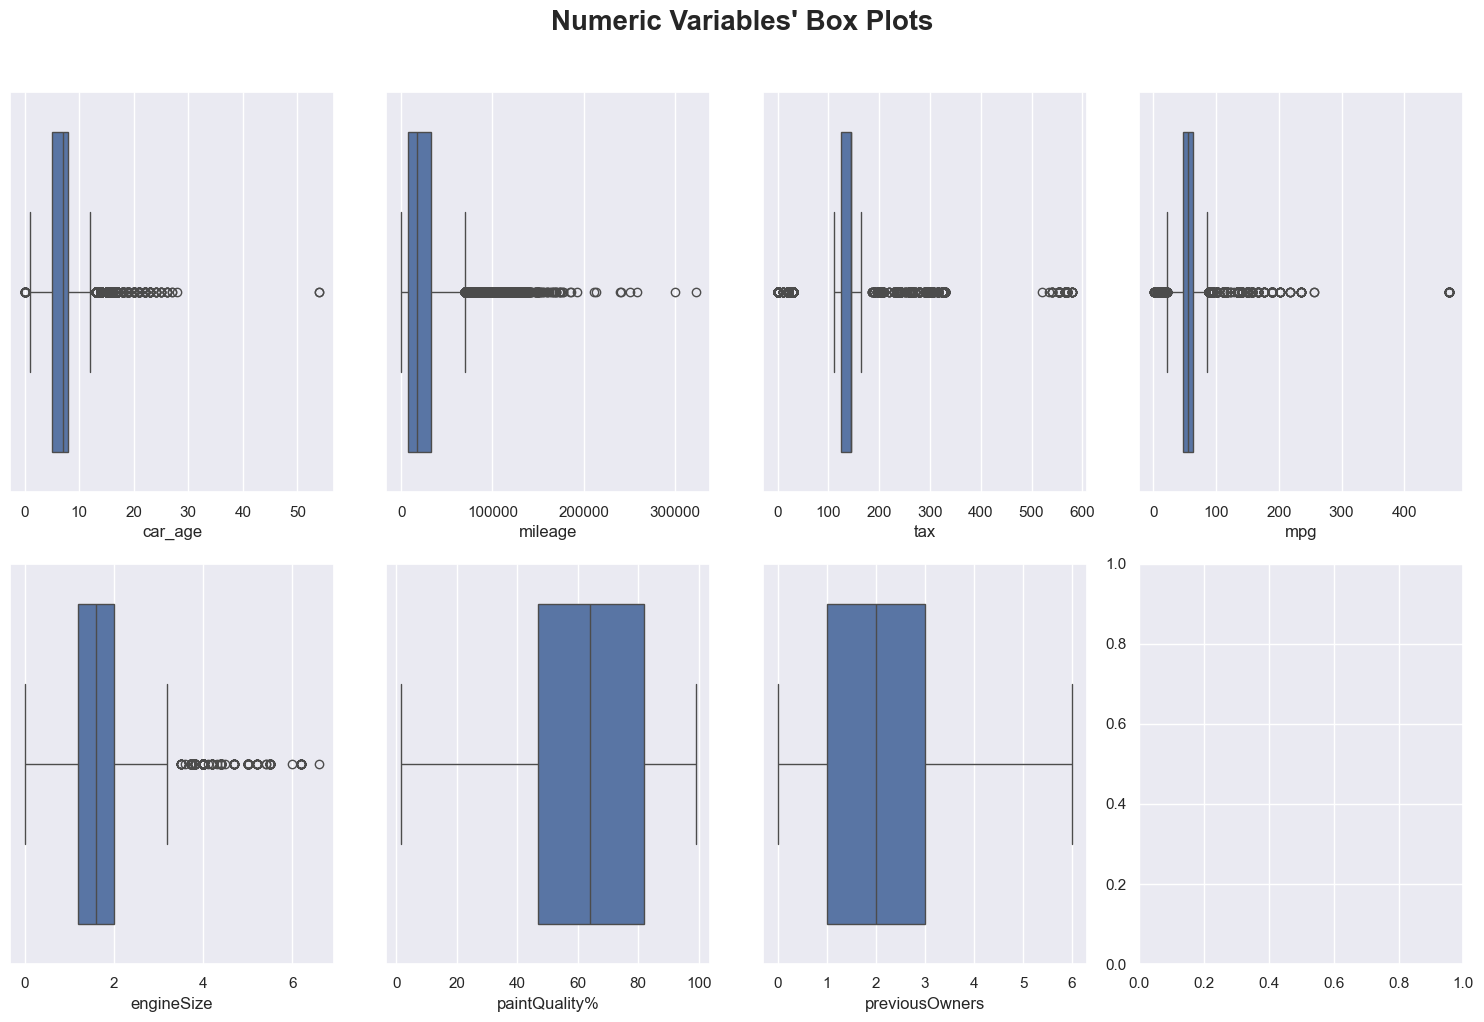

In [26]:
# Plot ALL Numeric Variables' Histograms in one figure

sns.set(style= "darkgrid", context= "notebook") ## Reset to darkgrid

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, 4, figsize=(15, 10),tight_layout=True)

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.boxplot(x=data[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
plt.suptitle("Numeric Variables' Box Plots", fontsize=20, y=1.02, fontweight='bold')
plt.show()

## Encoding Categorical Variables
[Back to TOC](#toc)

In [27]:
encoder_brand = OneHotEncoder(feature_name_combiner=custom_combiner, sparse_output=False)
encoded_brand = encoder_brand.fit_transform(X_train[["Brand"]])

# Convert encoded output to DataFrame (with feature names)
encoded_df_brand = pd.DataFrame(encoded_brand, columns=encoder_brand.get_feature_names_out(), index=X_train.index)

# Concatenate back with original (if you want)
X_train = pd.concat([X_train, encoded_df_brand], axis=1)

In [28]:
encoders_by_brand = {} # dictionary to store one LabelEncoder per brand

for brand in X_train["Brand"].unique().tolist():
    le = LabelEncoder()
    labels = le.fit_transform(X_train.loc[X_train["Brand"] == brand, "model"])
    X_train.loc[X_train[brand] == 1, brand] = labels
    encoders_by_brand[brand] = le  # save the encoder for this brand

In [29]:
X_train.drop(columns= ["Brand", "model"], inplace=True)

In [30]:

encoder_fuelType = OneHotEncoder(feature_name_combiner=custom_combiner, sparse_output=False, drop = ["Other"])
encoded_fuelType = encoder_fuelType.fit_transform(X_train[["fuelType"]])

# Convert encoded output to DataFrame (with feature names)
encoded_df_fuelType = pd.DataFrame(encoded_fuelType, columns=encoder_fuelType.get_feature_names_out(), index=X_train.index)

# Concatenate back with original (if you want)
X_train = pd.concat([X_train, encoded_df_fuelType], axis=1)
X_train.drop("fuelType", axis= 1, inplace= True)


In [31]:
encoder_transmission = OneHotEncoder(feature_name_combiner=custom_combiner, sparse_output=False, drop = ["Other"])
encoded_transmission = encoder_transmission.fit_transform(X_train[["transmission"]])

# Convert encoded output to DataFrame (with feature names)
encoded_df_transmission = pd.DataFrame(encoded_transmission, columns=encoder_transmission.get_feature_names_out(), index=X_train.index)

# Concatenate back with original (if you want)
X_train = pd.concat([X_train, encoded_df_transmission], axis=1)
X_train.drop("transmission", axis= 1, inplace= True)

## Feature Engeneering
[Back to TOC](#toc)

Having the car age is more interpretable for the model then having the car year. We can say this because the year alreay starts in a very high value, while car age would start at 0.

In [61]:
X_train

,car_age,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,Audi,BMW,Ford,Hyundai,Mercedes,Opel,Skoda,Toyota,VW,Diesel,Hybrid,Petrol,nan,Automatic,Manual,Semi-Auto,Unknown,nan
carID,,,,,,,,,,,,,,,,,,,,,,,,,
31106,9.0,25169.0,0.0,74.3,1.5,38.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
52908,21.0,167054.0,205.0,48.7,2.0,36.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
21218,7.0,12456.0,NaN,NaN,1.0,68.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
15728,14.0,54869.0,150.0,NaN,1.6,33.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
68286,7.0,47445.0,150.0,54.3,2.0,78.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49404,5.0,11064.0,145.0,42.2,2.0,95.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10488,5.0,4665.0,150.0,52.3,2.0,87.0,1.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30313,11.0,15268.0,30.0,54.3,1.2,38.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


## Data Scaling
[Back to TOC](#toc)

# Data Cleaning and Pre-processing of Test Dataset

In [32]:
data = pd.read_csv("D:/Faculdade/Mestrado/Data Mining/Data Mining_ Materials/ML_Project_Group42/data/test.csv", index_col= "carID")
pd.set_option("display.max_columns", None)

## Data Cleaning - Test Dataset

### "year"

The year variable can only have integers values

In [33]:
data["year"] = data["year"].apply(lambda x: math.floor(x) if pd.notna(x) else x)
data["year"].describe()

count    31914.000000
mean      2017.097042
std          2.209278
min       1991.000000
25%       2016.000000
50%       2017.000000
75%       2019.000000
max       2024.000000
Name: year, dtype: float64

Converting "year" to "car_age"

In [34]:
data["year"] = 2024 - data["year"]
data.rename(columns={"year": "car_age"}, inplace= True)
data

,Brand,model,car_age,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
89856,Hyundai,I30,2.0,Automatic,30700.000000,petrol,205.0,41.5,1.6,61.0,3.0,0.0
106581,VW,Tiguan,7.0,Semi-Auto,-48190.655673,Petrol,150.0,38.2,2.0,60.0,2.0,0.0
80886,BMW,2 Series,8.0,Automatic,36792.000000,Petrol,125.0,51.4,1.5,94.0,2.0,0.0
100174,Opel,Grandland X,5.0,Manual,5533.000000,Petrol,145.0,44.1,1.2,77.0,1.0,0.0
81376,BMW,1 Series,5.0,Semi-Auto,9058.000000,Diesel,150.0,51.4,2.0,45.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
105775,VW,Tiguan,7.0,Manual,27575.000000,Petrol,145.0,46.3,1.4,94.0,1.0,0.0
81363,BMW,X2,4.0,Automatic,1980.000000,Petrol,145.0,34.0,2.0,39.0,3.0,0.0
76833,Audi,Q5,5.0,Semi-Auto,8297.000000,Diesel,145.0,38.2,2.0,88.0,4.0,0.0


### "mileage"

Transforming negative values in mileage to nan

In [35]:
data["mileage"][data["mileage"] < 0] = np.nan

C:\Users\andre\AppData\Local\Temp\ipykernel_14332\2415613594.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data["mileage"][data["mileage"] < 0] = np.nan
C:\Users\andre\AppData\Local\Temp\ipykernel_14332\2415613594.py:1: SettingWithCopy

### "Tax"

Same as with mileage, converting negative values to nan

In [36]:
data["tax"][data["tax"] < 0] = np.nan

C:\Users\andre\AppData\Local\Temp\ipykernel_14332\839513193.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data["tax"][data["tax"] < 0] = np.nan
C:\Users\andre\AppData\Local\Temp\ipykernel_14332\839513193.py:1: SettingWithCopyWarning: 


### "mpg"

The same as before

In [37]:
data["mpg"][data["mpg"] < 0] = np.nan

C:\Users\andre\AppData\Local\Temp\ipykernel_14332\1243779187.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data["mpg"][data["mpg"] < 0] = np.nan
C:\Users\andre\AppData\Local\Temp\ipykernel_14332\1243779187.py:1: SettingWithCopyWarning:

### "engineSize"

same as before

In [38]:
data["engineSize"][data["engineSize"] < 0] = np.nan

C:\Users\andre\AppData\Local\Temp\ipykernel_14332\457097309.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data["engineSize"][data["engineSize"] < 0] = np.nan
C:\Users\andre\AppData\Local\Temp\ipykernel_14332\457097309.py:1: SettingWith

### "previousOwners"

same as before

In [39]:
data["previousOwners"][data["previousOwners"] < 0] = np.nan

C:\Users\andre\AppData\Local\Temp\ipykernel_14332\2453159554.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data["previousOwners"][data["previousOwners"] < 0] = np.nan
C:\Users\andre\AppData\Local\Temp\ipykernel_14332\2453159554.py:1: S

In "previousOwners" all values have to be integers

In [40]:
data["previousOwners"] = data["previousOwners"].apply(lambda x: math.floor(x) if pd.notna(x) else x)
data["previousOwners"].describe()

count    31802.000000
mean         2.027703
std          1.438231
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: previousOwners, dtype: float64

### "paintQuality%"

Converting to missing values values above 100%

In [41]:
data["paintQuality%"][data["paintQuality%"] > 100] = np.nan

C:\Users\andre\AppData\Local\Temp\ipykernel_14332\1763353316.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data["paintQuality%"][data["paintQuality%"] > 100] = np.nan
C:\Users\andre\AppData\Local\Temp\ipykernel_14332\1763353316.py:1: S

### "hasdamage"

Dropping hasdamage because it is an irrelevant feature

In [42]:
data.drop("hasDamage", axis = 1, inplace= True)

### Text normalization for categorical variables cleaning

Put everything in lower case and also eliminate some punctoation and extra spaces.

In [43]:
data["model"] = data["model"].apply(normalize_text)
data["Brand"] = data["Brand"].apply(normalize_text)
data["transmission"] = data["transmission"].apply(normalize_text)
data["fuelType"] = data["fuelType"].apply(normalize_text)

### "brand" variable cleaning

Cleaning of unique values of brand using a dictionary

In [44]:
correct_brands = {"Audi": ['aud', 'audi', 'udi', 'ud'],
                  "BMW": ['bmw', 'mw', 'bm'],
                  "Ford": ['ford', 'for', 'ord', 'or'],
                  "Hyundai" : ['hyundai', 'hyunda', 'yundai', 'yunda'],
                  "Mercedes" : ['mercedes','ercedes', 'mercede', 'ercede'],
                  "Skoda": ['skoda', 'koda', 'skod', 'kod'],
                  "Toyota": ['toyota', 'toyot', 'oyota'],
                  "Opel": ['opel', 'pel', 'ope', 'pe'],
                  "VW": ['vw', 'w','v']}

variant_to_brand = {variant: brand for brand, variants in correct_brands.items() for variant in variants}
data["Brand"] = data["Brand"].map(variant_to_brand)
data["Brand"].unique()

array(['Hyundai', 'VW', 'BMW', 'Opel', 'Ford', 'Mercedes', 'Skoda',
       'Toyota', 'Audi', nan], dtype=object)

### "model" variable cleaning

In [45]:
models_per_brand = pd.DataFrame(data.groupby(by =["Brand"])["model"].unique())
models_per_brand["model"] = models_per_brand["model"].apply(lambda x: [model for model in x if pd.notna(model)])
models_per_brand

,model
Brand,
Audi,"[tt, a4, a7, q2, a1, q5, a3, q3, q, a5, a6, a8..."
BMW,"[2 series, 1 series, x1, 5 series, 3 series, 4..."
Ford,"[fiesta, focus, ecosport, kuga, grand c-max, k..."
Hyundai,"[i30, ix20, i10, tucson, i40, ix35, i20, santa..."
Mercedes,"[b class, c class, m clas, e class, a class, x..."
Opel,"[grandland x, adam, zafira, corsa, insignia, m..."
Skoda,"[superb, fabia, octavia, karoq, kamiq, kodiaq,..."
Toyota,"[aygo, land cruiser, yaris, rav4, auris, corol..."
VW,"[tiguan, up, golf, passat, caravelle, polo, sh..."


In [46]:
models_per_brand["model"] = models_per_brand["model"].apply(lambda x: [re.sub(r'\bclas\b', 'class', str(model)) for model in x])
models_per_brand

,model
Brand,
Audi,"[tt, a4, a7, q2, a1, q5, a3, q3, q, a5, a6, a8..."
BMW,"[2 series, 1 series, x1, 5 series, 3 series, 4..."
Ford,"[fiesta, focus, ecosport, kuga, grand c-max, k..."
Hyundai,"[i30, ix20, i10, tucson, i40, ix35, i20, santa..."
Mercedes,"[b class, c class, m class, e class, a class, ..."
Opel,"[grandland x, adam, zafira, corsa, insignia, m..."
Skoda,"[superb, fabia, octavia, karoq, kamiq, kodiaq,..."
Toyota,"[aygo, land cruiser, yaris, rav4, auris, corol..."
VW,"[tiguan, up, golf, passat, caravelle, polo, sh..."


In [47]:
brands = models_per_brand.index.tolist()

for models, brand in zip(models_per_brand["model"], brands):
    canonical_names = {}  # to store canonical form for each variant

    for model in models:
        if model in canonical_names:
            continue  # already assigned

        # adaptive threshold
        threshold = 90 if len(model) < 4 else 75

        # find similar models within this brand
        matches = process.extract(model, models, scorer=fuzz.token_sort_ratio)
        close = [m for m, score, _ in matches if score >= threshold]
        for c in close:
            canonical_names[c] = model  # group under canonical name

    data.loc[data["Brand"] == brand , "model"] = data.loc[data["Brand"] == brand, "model"].map(canonical_names).fillna(data.loc[data["Brand"] == brand, "model"])

data["model"] = data["model"].str.capitalize()

In [48]:
canonical_names = {key: value for key, value in canonical_names.items() if key != value}
canonical_names

{'tigua': 'tiguan',
 'gol': 'golf',
 'golf s': 'golf sv',
 'passa': 'passat',
 'caravell': 'caravelle',
 'pol': 'polo',
 'toura': 'touran',
 't-ro': 't-roc',
 'scirocc': 'scirocco',
 'shara': 'sharan',
 'californi': 'california',
 'arteo': 'arteon',
 'tiguan allspac': 'tiguan allspace',
 'caddy life': 'caddy maxi life'}

### "fuelType" variable cleaning

In [49]:
correct_fueltype = {"Diesel": ["diesel", "iesel", "diese", "iese"],
                    "Petrol": ["petrol", "petro", "etrol", "etro"],
                    "Hybrid": ["hybrid", "ybrid", "hybri", "ybri"],
                    "Other": ["other", "ther", "othe"],
                    "Eletric": "eletric"}

variant_to_fuelType = {variant: fuelType for fuelType, variants in correct_fueltype.items() for variant in variants}
data["fuelType"] = data["fuelType"].map(variant_to_fuelType)
data["fuelType"].unique()

array(['Petrol', 'Diesel', 'Hybrid', nan, 'Other'], dtype=object)

### "transmission" variable cleaning

In [50]:
correct_transmissions = {
    "Manual": ["manual", "anual", "manua", "anua"],
    "Semi-Auto": ["semi-auto", "emi-auto", "semi-aut", "emi-aut"],
    "Automatic": ["automatic", "automati", "utomatic", "utomati"],
    "Unknown": ["unknown", "unknow", "nknown", "nknow"],"Other": ["other"]}

variant_to_transmissions = {variant: transmissions for transmissions, variants in correct_transmissions.items() for variant in variants}
data["transmission"] = data["transmission"].map(variant_to_transmissions)
data["transmission"].unique()

array(['Automatic', 'Semi-Auto', 'Manual', 'Unknown', nan, 'Other'],
      dtype=object)

### "Brand" missing values filling

Filling missing values in brand through the model variable

In [51]:
brand_per_model = (
    data.groupby("model")["Brand"]
        .unique()                       # get unique brands per model (still lists)
        .apply(lambda x: [b for b in x if pd.notna(b)])  # remove NaNs
        .apply(lambda x: x[0] if len(x) > 0 else None) # take first brand as string
        .to_dict()                        # convert to dictionary
)

brand_per_model

{'1 series': None,
 '180': 'Mercedes',
 '2 series': None,
 '3 serie': 'BMW',
 '3 series': None,
 '4 series': 'BMW',
 '5 serie': 'BMW',
 '5 series': None,
 '6 series': 'BMW',
 '7 series': 'BMW',
 '8 series': 'BMW',
 'A': 'Audi',
 'A clas': 'Mercedes',
 'A class': None,
 'A1': 'Audi',
 'A3': 'Audi',
 'A4': 'Audi',
 'A5': 'Audi',
 'A6': 'Audi',
 'A7': 'Audi',
 'A8': 'Audi',
 'Adam': 'Opel',
 'Agila': 'Opel',
 'Amarok': 'VW',
 'Amica': None,
 'Ampera': 'Opel',
 'Antara': 'Opel',
 'Arteon': 'VW',
 'Astra': 'Opel',
 'Auri': 'Toyota',
 'Auris': None,
 'Avensis': 'Toyota',
 'Aygo': 'Toyota',
 'B clas': 'Mercedes',
 'B class': 'Mercedes',
 'B-ma': 'Ford',
 'B-max': None,
 'Beetle': 'VW',
 'C clas': 'Mercedes',
 'C class': None,
 'C-hr': 'Toyota',
 'C-max': 'Ford',
 'Caddy': 'VW',
 'Caddy maxi life': 'VW',
 'California': 'VW',
 'Camry': 'Toyota',
 'Caravelle': 'VW',
 'Cascada': 'Opel',
 'Cc': 'VW',
 'Citigo': 'Skoda',
 'Cl clas': 'Mercedes',
 'Cl class': 'Mercedes',
 'Cla clas': 'Mercedes',
 'Cl

In [52]:
data["Brand"].isna().sum()

np.int64(652)

In [53]:
data["Brand"] = data["Brand"].fillna(data["model"].map(brand_per_model))
print(f"We reduced the number of missing values in 'Brand' from 652 to {data['Brand'].isna().sum()}, which means we filled {652-data['Brand'].isna().sum()} rows.")

We reduced the number of missing values in 'Brand' from 652 to 175, which means we filled 477 rows.


## Data Preprocessing - Test Dataset

### Missing values

In [54]:
data.isna().sum()

Brand              175
model              650
car_age            653
transmission       623
mileage            859
fuelType           657
tax               3469
mpg               3305
engineSize         661
paintQuality%      793
previousOwners     765
dtype: int64

Dropping Nan of brands

In [55]:
data.dropna(subset=["Brand"], inplace=True)

### Filling of numerical features

Impute numerical missing values based on scalers an imputers from trainning

In [56]:
for brand, df_brand in data.groupby("Brand"):

    scaler = Brand_scalers[brand]       #Getting the scaler and the imputer from the dictionaries
    imputer = Brand_imputers[brand]

    scaled_val = scaler.transform(df_brand[scaler.feature_names_in_]) #Transform using X_train Scalers
    imputed_scaled = imputer.transform(scaled_val)           #Transform using X_train imputers
        
    data.loc[df_brand.index, scaler.feature_names_in_] = scaler.inverse_transform(imputed_scaled) #Reverse the scaling

In [57]:
data.isna().sum()

Brand               0
model             634
car_age             0
transmission      620
mileage             0
fuelType          654
tax                 0
mpg                 0
engineSize          0
paintQuality%       0
previousOwners      0
dtype: int64

### Fill Categorical Features

In [58]:
for brand, df_brand in data.groupby("Brand"):
    for col in non_metric_features:
        mode_value = brand_modes[brand][col]
        data.loc[df_brand.index, col] = df_brand[col].fillna(mode_value)

In [59]:
data.isna().sum()

Brand             0
model             0
car_age           0
transmission      0
mileage           0
fuelType          0
tax               0
mpg               0
engineSize        0
paintQuality%     0
previousOwners    0
dtype: int64

### Outliers

Removing outliers using the same reasoning applied when handling outliers in the training data.

In [60]:

outliers_col = ["car_age", "mileage", "tax", "mpg"]

for col in outliers_col:

    if col == "car_age" or col == "mileage":
        q_1 = data[col].quantile(0.25)
        q_3 = data[col].quantile(0.75)
        IQR = q_3 - q_1
        data[col] = np.clip(data[col], q_1 - 3 * IQR , q_3 + 3 * IQR) # Only severe outliers capped
        
    else:
        q_1 = data[col].quantile(0.25)
        q_3 = data[col].quantile(0.75)
        IQR = q_3 - q_1
        data[col] = np.clip(data[col], q_1 - 1.5 * IQR , q_3 + 1.5 * IQR)

### Encoding of Categorical Variables